## Import

In [1]:
import os
import psycopg2
from dotenv import load_dotenv

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge


# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
plt.style.use('seaborn')

# Affichage cellule
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_row', 1000)
from pprint import pprint

# Chargement du model pour déploiement
import pickle

## Connection à la DB sécurisé via des variables d'environnement

### création de la chaine de connexion

In [2]:


load_dotenv()  # Nécessaire pour charger les variables d'environnement précédemment définies

# Créer une connexion à postgres
connection = psycopg2.connect(host=os.environ.get('PG_HOST'),
                        user=os.environ.get('PG_USER'),
                        password=os.environ.get('PG_PASSWORD'),
                        dbname=os.environ.get('PG_DATABASE'))

connection.autocommit = True  # Assurez-vous que les données sont ajoutées à la base de données immédiatement après les commandes d'écriture.
cursor = connection.cursor()
cursor.execute('SELECT %s as connected;', ('Connection à postgres Réussie!',))
print(cursor.fetchone())

('Connection à postgres Réussie!',)


### Fonction de création du dataframe

In [3]:
def postgresql_to_dataframe(conn, select_query, column_names):
    """
    Transformer une requête SELECT en un dataframe pandas
    """
    cursor = conn.cursor()
    try:
        cursor.execute(select_query)
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        cursor.close()
        return 1
    
    # Naturellement, nous obtenons une liste de "tupples".
    tupples = cursor.fetchall()
    cursor.close()
    
    # Nous devons juste le transformer en dataframe pandas.
    df = pd.DataFrame(tupples, columns=column_names)
    return df

### Récupération de postgresql au dataframe

In [4]:
conn = connection
column_names = ["user_id","gender", "age", "height", "weight", "duration", "heart_rate", "body_temp", "calorie"]
# Execute the "SELECT *" query
df_db = postgresql_to_dataframe(conn, 
"SELECT persons.user_id as id, gender, age, height, weight, duration, heart_rate, body_temp,calorie FROM calories INNER JOIN persons ON calories.user_id = persons.user_id"
                                , column_names)
df_db.head()

,user_id,gender,age,height,weight,duration,heart_rate,body_temp,calorie
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0


In [18]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

ohe=OneHotEncoder(sparse=False)

ct=make_column_transformer((ohe,['gender']))
data_ct=ct.fit_transform(df_db)

# Encodage sur le genre et retransformation en dataframe pandas nommé dum
ohe_True=OneHotEncoder(sparse=True)
ohe_with_sparse=ohe_True.fit_transform(df_db['gender'].values.reshape(-1,1)).toarray()
ohe_with_sparse

dum_scaler=pd.get_dummies(df_db,columns=['gender'],prefix='',prefix_sep='')

## Modele

In [22]:
# # utilisation des doubles crochets pour renvoyer un DataFrame pour la variable  X
X = dum_scaler.drop(['calorie','user_id'] , axis=1)
# y unidimensionnel
y = dum_scaler['calorie']

In [25]:
from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(
    X, y, random_state=42)

In [27]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(data_train)

StandardScaler()

In [28]:
scaler.mean_

array([ 42.78355556, 174.38142222,  74.88746667,  15.47964444,
        95.4968    ,  40.02089778,   0.50506667,   0.49493333])

In [29]:
scaler.scale_

array([16.94382341, 14.22474938, 15.01583026,  8.31599176,  9.54997329,
        0.78070378,  0.49997433,  0.49997433])

In [30]:
data_train_scaled = scaler.transform(data_train)
data_train_scaled

array([[ 0.36688558, -0.09711399,  0.0740907 , ...,  0.99794857,
        -1.0101852 ,  1.0101852 ],
       [-0.28231854,  0.11378603,  0.54026539, ...,  0.74176946,
        -1.0101852 ,  1.0101852 ],
       [ 0.89805259, -0.167414  ,  0.14068708, ..., -0.92339476,
        -1.0101852 ,  1.0101852 ],
       ...,
       [ 0.83903403,  1.02768614,  1.13963284, ..., -0.66721565,
        -1.0101852 ,  1.0101852 ],
       [-0.45937421, -0.02681399,  0.0740907 , ...,  0.22941124,
        -1.0101852 ,  1.0101852 ],
       [-0.99054122,  0.53558608,  0.74005454, ...,  0.6136799 ,
        -1.0101852 ,  1.0101852 ]])

In [31]:
data_train_scaled = scaler.fit_transform(data_train)
data_train_scaled

array([[ 0.36688558, -0.09711399,  0.0740907 , ...,  0.99794857,
        -1.0101852 ,  1.0101852 ],
       [-0.28231854,  0.11378603,  0.54026539, ...,  0.74176946,
        -1.0101852 ,  1.0101852 ],
       [ 0.89805259, -0.167414  ,  0.14068708, ..., -0.92339476,
        -1.0101852 ,  1.0101852 ],
       ...,
       [ 0.83903403,  1.02768614,  1.13963284, ..., -0.66721565,
        -1.0101852 ,  1.0101852 ],
       [-0.45937421, -0.02681399,  0.0740907 , ...,  0.22941124,
        -1.0101852 ,  1.0101852 ],
       [-0.99054122,  0.53558608,  0.74005454, ...,  0.6136799 ,
        -1.0101852 ,  1.0101852 ]])

In [32]:
data_train_scaled = pd.DataFrame(data_train_scaled,
                                 columns=data_train.columns)
data_train_scaled.describe()

,age,height,weight,duration,heart_rate,body_temp,female,male
count,1.125000e+04,1.125000e+04,1.125000e+04,1.125000e+04,1.125000e+04,1.125000e+04,1.125000e+04,1.125000e+04
mean,-1.052097e-16,-3.121750e-16,-1.268121e-16,-4.731277e-17,7.410467e-16,2.077311e-15,3.081782e-16,-3.081782e-16
std,1.000044e+00,1.000044e+00,1.000044e+00,1.000044e+00,1.000044e+00,1.000044e+00,1.000044e+00,1.000044e+00
min,-1.344653e+00,-3.612114e+00,-2.589765e+00,-1.741181e+00,-2.983966e+00,-3.741365e+00,-1.010185e+00,-9.899175e-01
25%,-8.725041e-01,-7.298141e-01,-7.916623e-01,-8.994290e-01,-7.850074e-01,-5.391261e-01,-1.010185e+00,-9.899175e-01
50%,-2.233000e-01,-2.681399e-02,-5.910207e-02,-5.767736e-02,-5.202109e-02,2.294112e-01,9.899175e-01,-9.899175e-01
75%,7.800155e-01,7.464861e-01,7.400545e-01,9.043246e-01,7.856776e-01,7.417695e-01,9.899175e-01,1.010185e+00
max,2.137442e+00,3.066386e+00,3.803488e+00,1.746076e+00,3.403486e+00,1.894575e+00,9.899175e-01,1.010185e+00


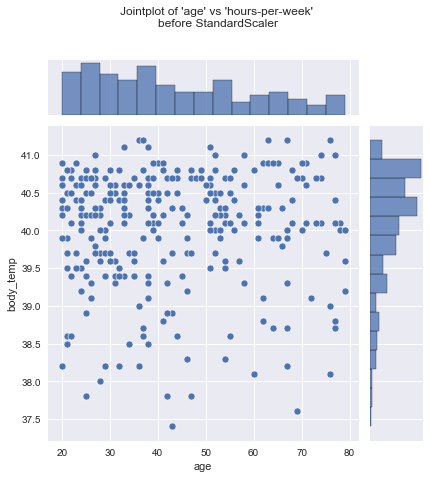

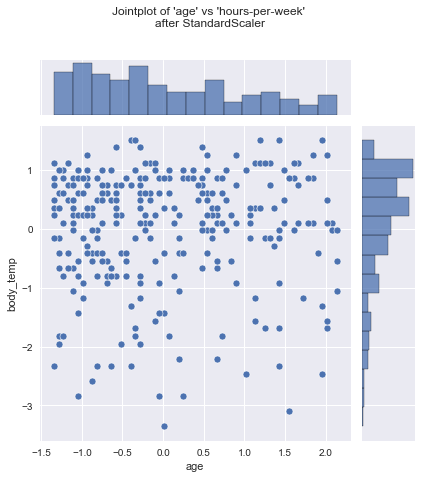

In [38]:
import matplotlib.pyplot  as plt
import seaborn as sns

# number of points to visualize to have a clearer plot
num_points_to_plot = 300

sns.jointplot(data=data_train[:num_points_to_plot], x="age",
              y="body_temp", marginal_kws=dict(bins=15))
plt.suptitle("Jointplot of 'age' vs 'hours-per-week' \nbefore StandardScaler", y=1.1)

sns.jointplot(data=data_train_scaled[:num_points_to_plot], x="age",
              y="body_temp", marginal_kws=dict(bins=15))
_ = plt.suptitle("Jointplot of 'age' vs 'hours-per-week' \nafter StandardScaler", y=1.1)

In [39]:
import time
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(), LinearRegression())
model

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [40]:
model.named_steps

{'standardscaler': StandardScaler(), 'linearregression': LinearRegression()}

In [41]:
start = time.time()
model.fit(data_train, target_train)
elapsed_time = time.time() - start

In [42]:
predicted_target = model.predict(data_test)
predicted_target[:5]

array([170.63972692, 192.28863683,  56.11749395, 155.66704601,
       212.31199728])

In [45]:
model.score(data_test,target_test)

0.9664885791583727

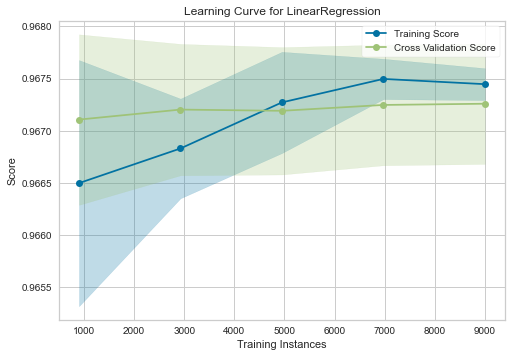

<AxesSubplot:title={'center':'Learning Curve for LinearRegression'}, xlabel='Training Instances', ylabel='Score'>

In [47]:
from yellowbrick.model_selection import LearningCurve

visualizer = LearningCurve(model, scoring='r2')

visualizer.fit(data_train, target_train)        # Fit the data to the visualizer
visualizer.show()           

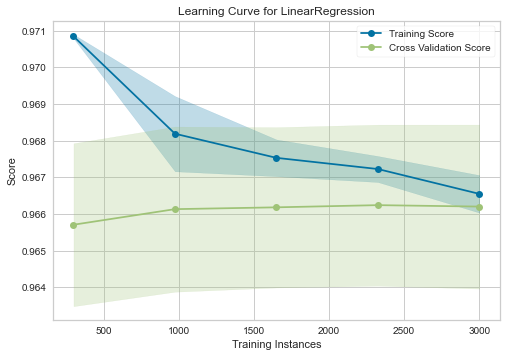

<AxesSubplot:title={'center':'Learning Curve for LinearRegression'}, xlabel='Training Instances', ylabel='Score'>

In [48]:
from yellowbrick.model_selection import LearningCurve

visualizer = LearningCurve(model, scoring='r2')

visualizer.fit(data_test,target_test)        # Fit the data to the visualizer
visualizer.show()           